In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
# from scanpy.plotting._tools.scatterplots import plot_scatter
import seaborn as sns
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

In [2]:
# set a working directory
wdir = '.'
os.chdir( wdir )

# path to loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'outputs/ecto_scenic_integrated-output.loom'

In [3]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=150)

-----
anndata     0.10.9
scanpy      1.10.3
-----
MulticoreTSNE               NA
PIL                         10.4.0
adjustText                  1.3.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        24.2.0
attrs                       24.2.0
babel                       2.16.0
backports                   NA
boltons                     NA
certifi                     2024.08.30
cffi                        1.17.1
charset_normalizer          3.4.0
cloudpickle                 3.1.0
comm                        0.2.2
ctxcore                     0.2.0
cycler                      0.12.1
cython_runtime              NA
cytoolz                     1.0.0
dask                        2024.2.1
dateutil                    2.9.0.post0
debugpy                     1.8.7
decorator                   5.1.1
defusedxml                  0.7.1
dill                        0.3.9
exceptiongroup              1.2.2
executing                   2.

/home/jacky/miniconda3/envs/scenic1.01/lib/python3.10/site-packages/session_info/main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)


### Extract relevant data from the integrated loom file

In [4]:
# scenic output
lf = lp.connect( f_final_loom, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [5]:
# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)

/tmp/ipykernel_1897240/37080085.py:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():


In [6]:
# cell annotations from the loom column attributes:
cellAnnot = pd.concat(
    [
        pd.DataFrame( lf.ca.ClusterID, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.Cell_clusters_Scanpy, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.Percent_mito, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nGene, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nUMI, index=lf.ca.CellID ),
    ],
    axis=1
)
cellAnnot.columns = [
 'ClusterID',
 'Cell_clusters_Scanpy',
 'Percent_mito',
 'nGene',
 'nUMI']

In [7]:
# capture embeddings:
dr = [
    pd.DataFrame( lf.ca.Embedding, index=lf.ca.CellID )
]
dr_names = [
    meta['embeddings'][0]['name'].replace(" ","_")
]

# add other embeddings
drx = pd.DataFrame( lf.ca.Embeddings_X, index=lf.ca.CellID )
dry = pd.DataFrame( lf.ca.Embeddings_Y, index=lf.ca.CellID )

for i in range( len(drx.columns) ):
    dr.append( pd.concat( [ drx.iloc[:,i], dry.iloc[:,i] ], sort=False, axis=1, join='outer' ))
    dr_names.append( meta['embeddings'][i+1]['name'].replace(" ","_").replace('/','-') )

# rename columns:
for i,x in enumerate( dr ):
    x.columns = ['X','Y']

In [8]:
lf.close()

### Regulon specificity scores (RSS) across predicted cell types

In [9]:
rss_cellType = regulon_specificity_scores( auc_mtx, cellAnnot['Cell_clusters_Scanpy'] )
rss_cellType

,ANXA1_(+),ATF3_(+),BACH2_(+),BHLHE40_(+),CEBPB_(+),CEBPD_(+),CREB5_(+),CUX2_(+),DAB2_(+),DDIT3_(+),...,TBX3_(+),TCF4_(+),TEAD1_(+),TFAP2C_(+),THRB_(+),TP63_(+),TWIST1_(+),ZEB1_(+),ZFHX3_(+),ZFP82_(+)
04_Placode,0.282024,0.269246,0.262155,0.329107,0.330014,0.245900,0.247720,0.266231,0.293206,0.304490,...,0.368133,0.256216,0.208437,0.317595,0.470308,0.397724,0.283041,0.243509,0.260426,0.199180
01_Epiblast,0.322807,0.344497,0.300119,0.282539,0.264089,0.240021,0.309968,0.275059,0.274811,0.325057,...,0.263250,0.293559,0.331733,0.264668,0.237253,0.281821,0.311132,0.364580,0.392864,0.226427
08_Diencephalon,0.199421,0.210172,0.266576,0.220960,0.223416,0.223087,0.262282,0.242352,0.228374,0.214023,...,0.217503,0.201661,0.189793,0.189727,0.200739,0.215140,0.215369,0.309669,0.301020,0.239354
03_Epidermal,0.371238,0.303787,0.211458,0.342789,0.302135,0.237109,0.215352,0.221128,0.260364,0.297685,...,0.352360,0.234829,0.182123,0.378746,0.374927,0.393814,0.235349,0.204715,0.227022,0.185054
05_Neural_crest,0.269722,0.300648,0.328092,0.265645,0.275658,0.250610,0.330072,0.289772,0.308990,0.305718,...,0.267795,0.222239,0.236841,0.406374,0.215031,0.274751,0.257899,0.307613,0.311510,0.231372
06_Neuroectoderm,0.201375,0.236548,0.252075,0.216276,0.211708,0.205041,0.254353,0.235226,0.212909,0.227485,...,0.210675,0.209606,0.201333,0.195204,0.200038,0.206585,0.213635,0.254133,0.227149,0.219920
11_Roof_plate,0.218242,0.230843,0.215709,0.218367,0.220652,0.237823,0.218653,0.349664,0.247159,0.211348,...,0.216952,0.199571,0.187274,0.209003,0.190763,0.216856,0.215796,0.250269,0.222696,0.208114
07_Telencephalon,0.230186,0.296954,0.258779,0.266163,0.243145,0.232372,0.317449,0.281783,0.236963,0.283259,...,0.259878,0.263950,0.219195,0.231879,0.235623,0.252140,0.226320,0.291930,0.250607,0.236650
09_Mesencephalon,0.195883,0.214084,0.206901,0.209828,0.204528,0.201247,0.222094,0.223700,0.208023,0.205755,...,0.196571,0.194243,0.178895,0.188928,0.189433,0.198906,0.199807,0.229770,0.204026,0.214764
02_Non_neuroectoderm,0.212246,0.203631,0.227283,0.218315,0.223233,0.202137,0.221064,0.218402,0.221811,0.211012,...,0.218735,0.220640,0.209995,0.192643,0.205618,0.210125,0.291863,0.231567,0.230303,0.201781


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


ValueError: num must be an integer with 1 <= num <= 10, not 11

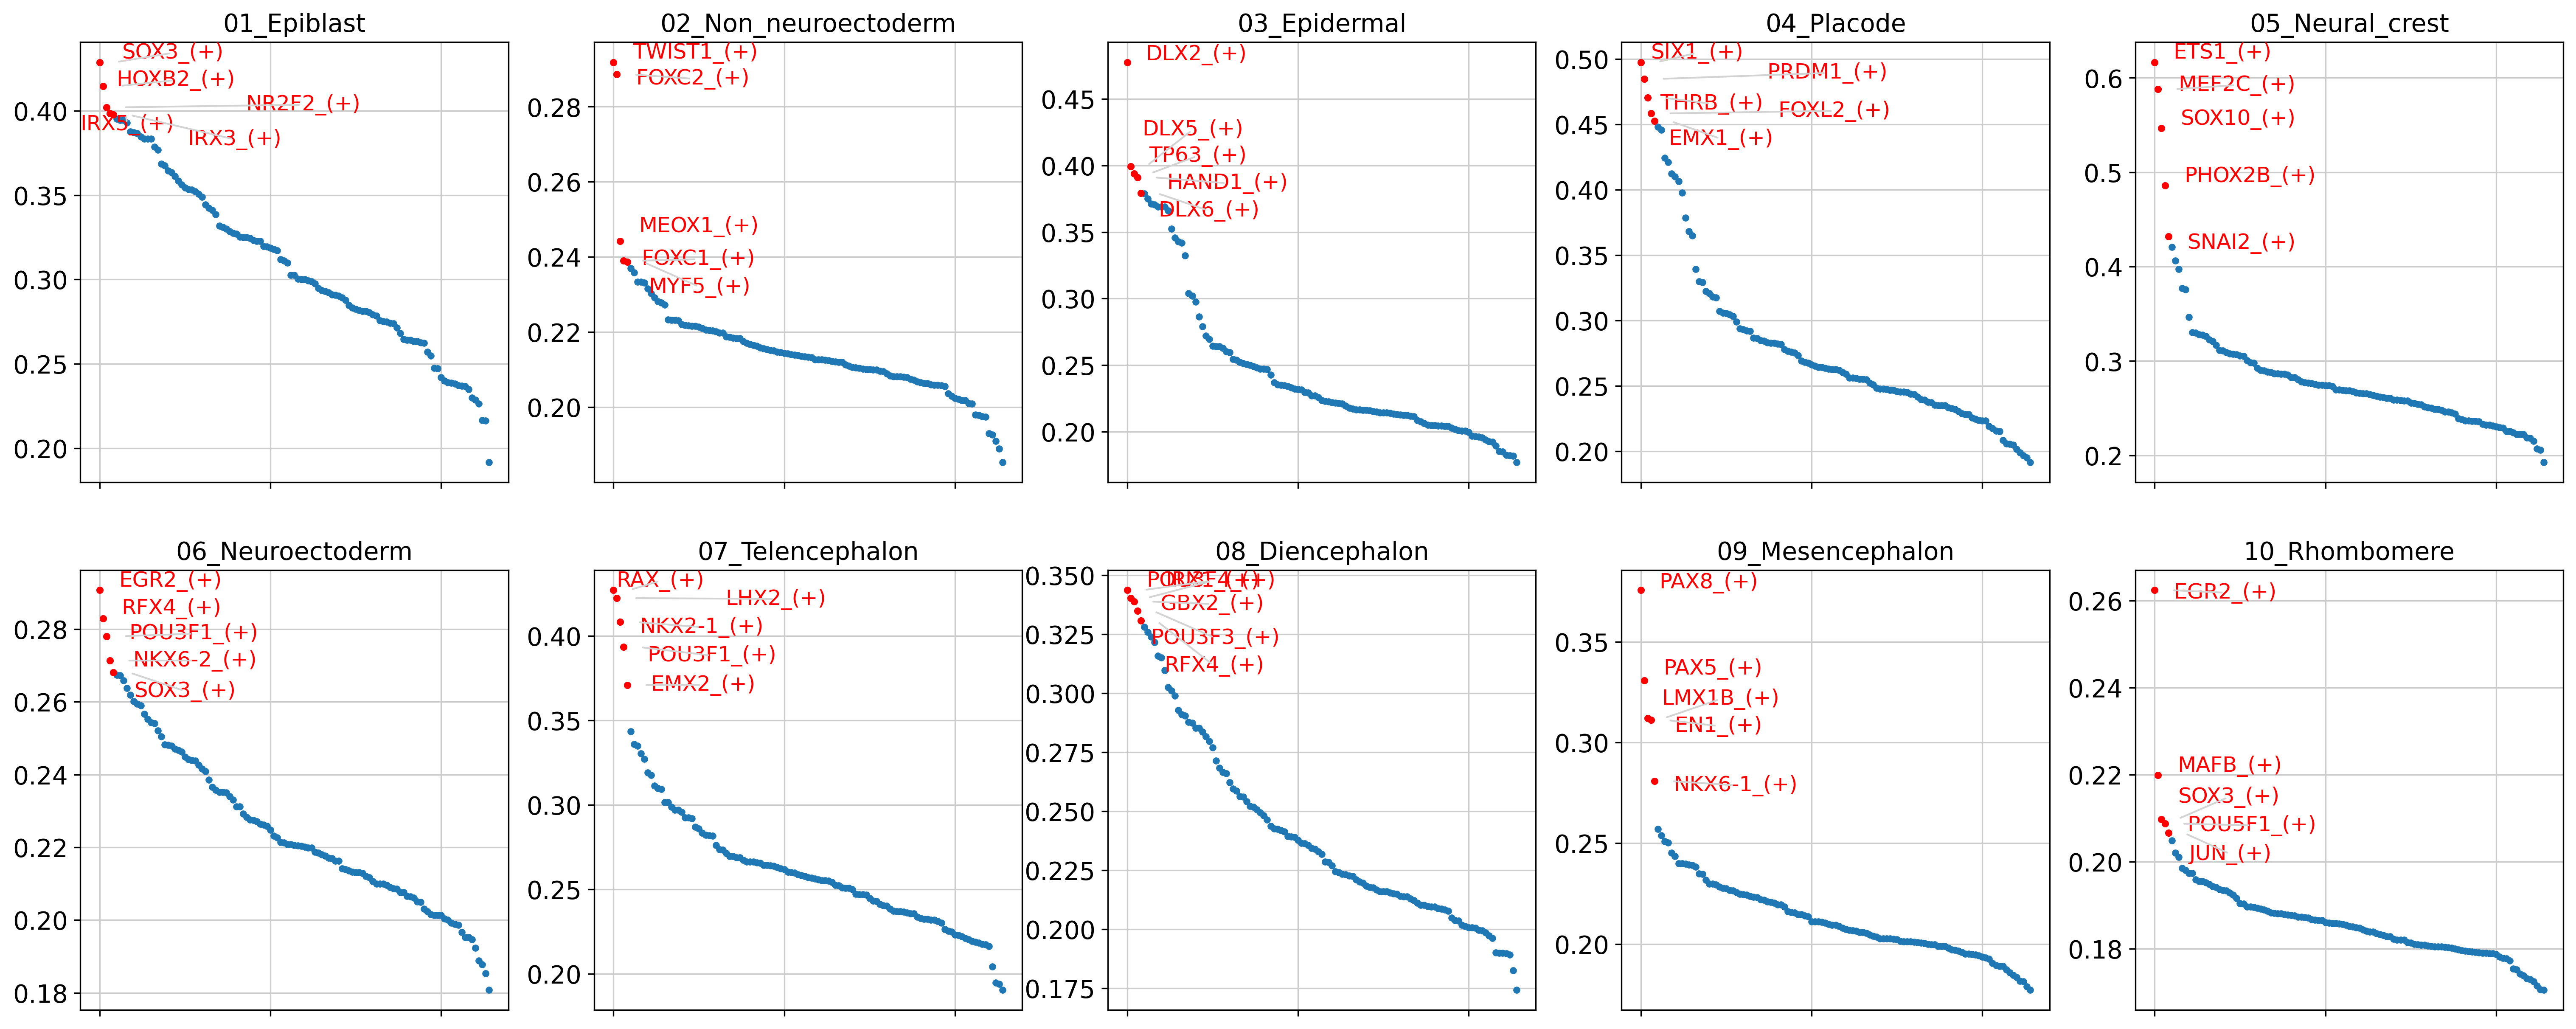

In [10]:
cats = sorted(list(set(cellAnnot['Cell_clusters_Scanpy'])))

fig = plt.figure(figsize=(25, 10))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(2,5,num)
    plot_rss(rss_cellType, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("plots/ecto_celltype-rss-top5.pdf", dpi=600, bbox_inches = "tight")
plt.show()

In [12]:
rss_celltype_t = rss_cellType.transpose()
rss_celltype_t.to_csv("outputs/rss_celltype.tsv",sep = "\t")
rss_celltype_t

,04_Placode,01_Epiblast,08_Diencephalon,03_Epidermal,05_Neural_crest,06_Neuroectoderm,11_Roof_plate,07_Telencephalon,09_Mesencephalon,02_Non_neuroectoderm,10_Rhombomere
ANXA1_(+),0.282024,0.322807,0.199421,0.371238,0.269722,0.201375,0.218242,0.230186,0.195883,0.212246,0.182827
ATF3_(+),0.269246,0.344497,0.210172,0.303787,0.300648,0.236548,0.230843,0.296954,0.214084,0.203631,0.201070
BACH2_(+),0.262155,0.300119,0.266576,0.211458,0.328092,0.252075,0.215709,0.258779,0.206901,0.227283,0.195924
BHLHE40_(+),0.329107,0.282539,0.220960,0.342789,0.265645,0.216276,0.218367,0.266163,0.209828,0.218315,0.185707
CEBPB_(+),0.330014,0.264089,0.223416,0.302135,0.275658,0.211708,0.220652,0.243145,0.204528,0.223233,0.180179
...,...,...,...,...,...,...,...,...,...,...,...
TP63_(+),0.397724,0.281821,0.215140,0.393814,0.274751,0.206585,0.216856,0.252140,0.198906,0.210125,0.179531
TWIST1_(+),0.283041,0.311132,0.215369,0.235349,0.257899,0.213635,0.215796,0.226320,0.199807,0.291863,0.175225
ZEB1_(+),0.243509,0.364580,0.309669,0.204715,0.307613,0.254133,0.250269,0.291930,0.229770,0.231567,0.186071
ZFHX3_(+),0.260426,0.392864,0.301020,0.227022,0.311510,0.227149,0.222696,0.250607,0.204026,0.230303,0.179822


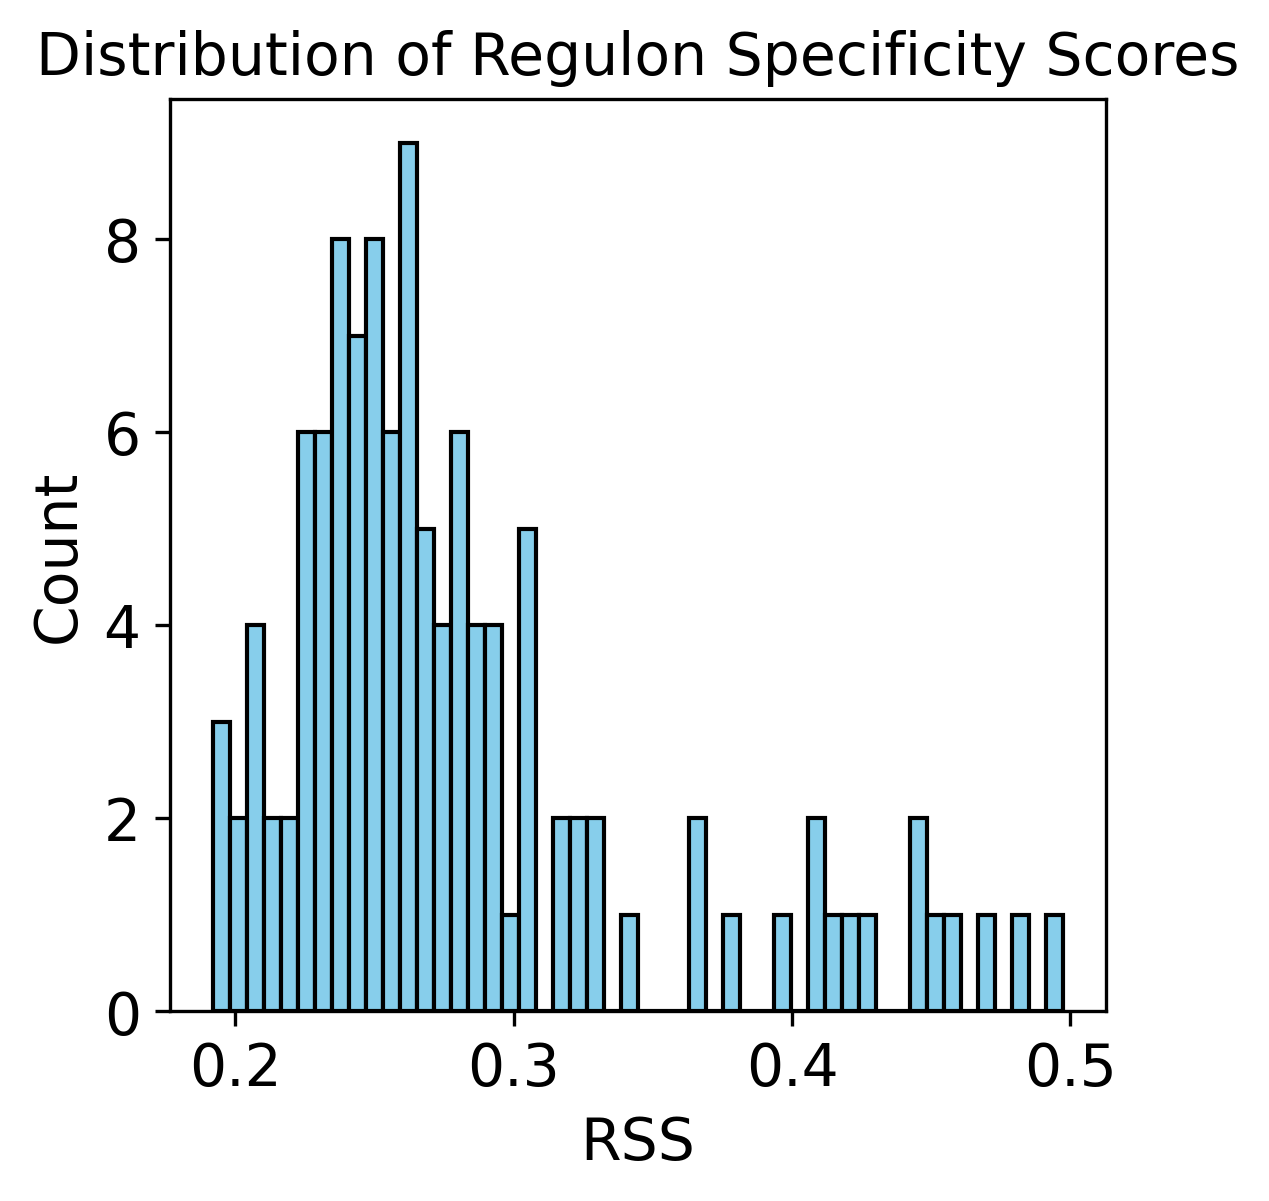

In [13]:
plt.hist(rss_celltype_t['04_Placode'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('RSS')
plt.ylabel('Count')
plt.title('Distribution of Regulon Specificity Scores')
plt.grid(False)  # similar to theme_classic()
plt.show()

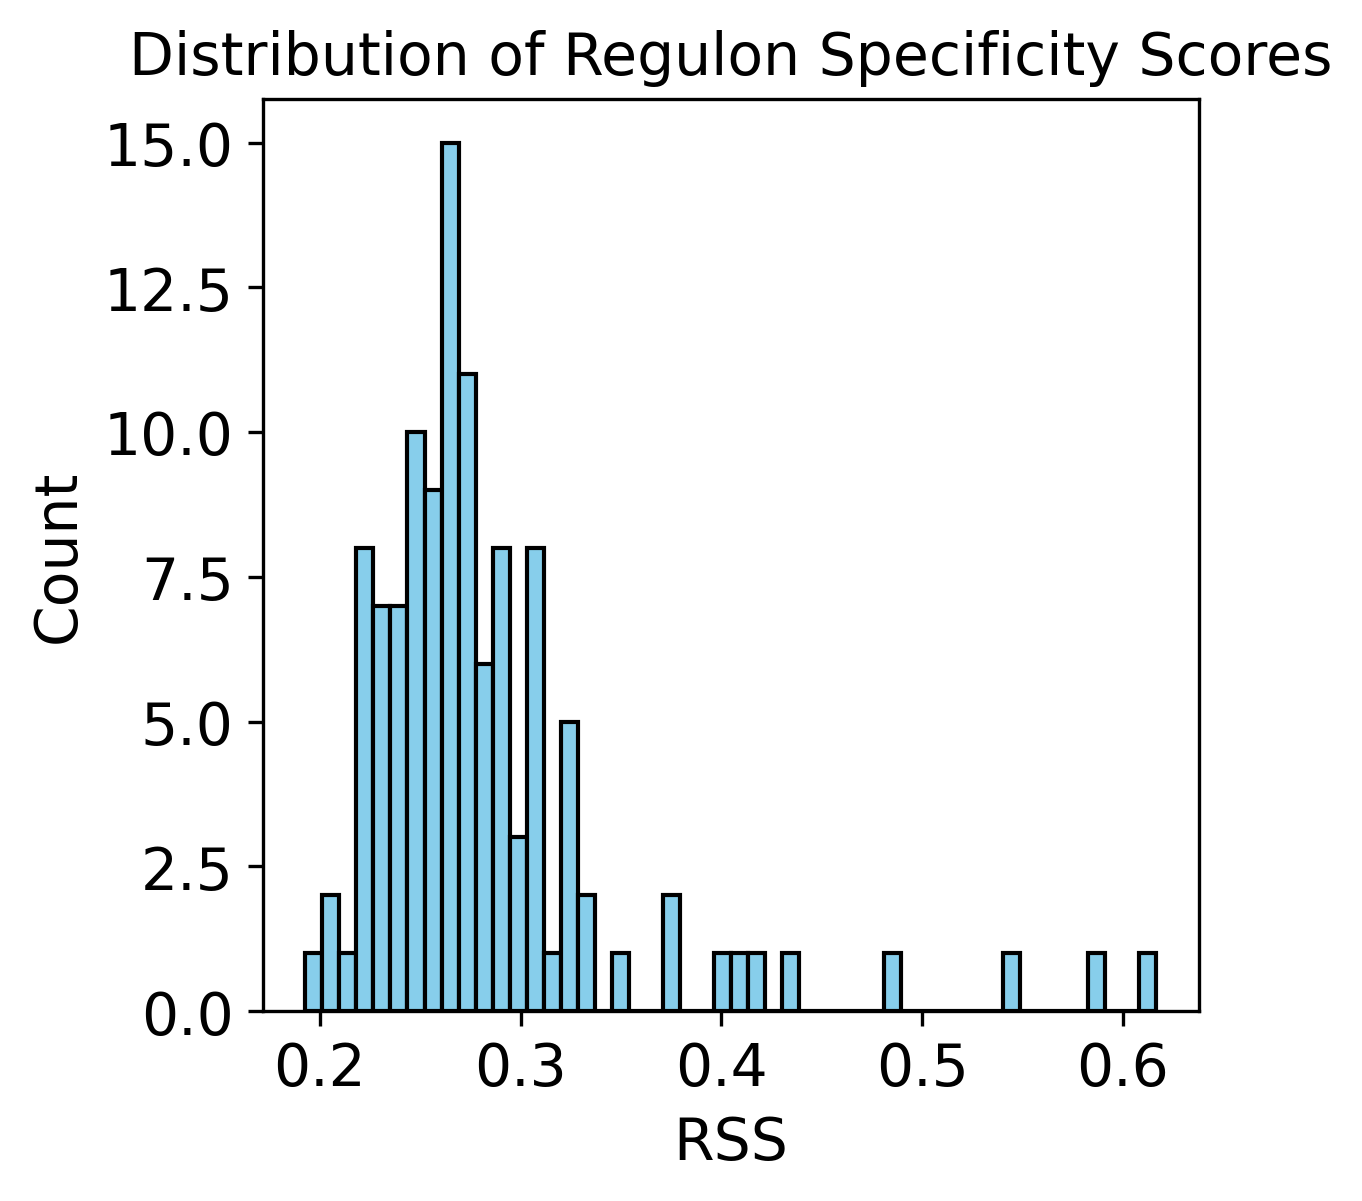

In [14]:
plt.hist(rss_celltype_t['05_Neural_crest'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('RSS')
plt.ylabel('Count')
plt.title('Distribution of Regulon Specificity Scores')
plt.grid(False)  # similar to theme_classic()
plt.show()

In [15]:
rss_celltype_t[rss_celltype_t['04_Placode'] > 0.35]

,04_Placode,01_Epiblast,08_Diencephalon,03_Epidermal,05_Neural_crest,06_Neuroectoderm,11_Roof_plate,07_Telencephalon,09_Mesencephalon,02_Non_neuroectoderm,10_Rhombomere
DLX5_(+),0.421046,0.262564,0.204824,0.399427,0.261722,0.202403,0.203807,0.264214,0.197280,0.202429,0.179298
DLX6_(+),0.364900,0.228610,0.200718,0.379316,0.258911,0.200437,0.203639,0.256972,0.207360,0.210190,0.178979
EMX1_(+),0.452564,0.254852,0.208800,0.253740,0.236486,0.213102,0.208800,0.257805,0.213549,0.219792,0.180994
FOXC1_(+),0.406521,0.290174,0.237729,0.264379,0.282652,0.214119,0.220975,0.254244,0.205759,0.239002,0.180840
FOXG1_(+),0.448053,0.239042,0.197252,0.250122,0.218305,0.201570,0.204728,0.292264,0.196921,0.214773,0.179020
FOXL2_(+),0.458388,0.229771,0.212111,0.242776,0.230311,0.207681,0.206715,0.240471,0.201208,0.217596,0.180505
GATA3_(+),0.409906,0.290688,0.213788,0.366157,0.276909,0.209996,0.216397,0.258122,0.200910,0.212426,0.181515
GRHL1_(+),0.445832,0.247346,0.199554,0.370431,0.225651,0.199254,0.202974,0.238322,0.192481,0.206064,0.180496
GRHL2_(+),0.424391,0.280577,0.213839,0.368981,0.265865,0.209923,0.213676,0.259614,0.201187,0.211969,0.181404
IKZF2_(+),0.378433,0.278350,0.212974,0.369124,0.253931,0.207618,0.225383,0.255103,0.200560,0.211299,0.179621


In [16]:
rss_celltype_t[rss_celltype_t['05_Neural_crest'] > 0.35]

,04_Placode,01_Epiblast,08_Diencephalon,03_Epidermal,05_Neural_crest,06_Neuroectoderm,11_Roof_plate,07_Telencephalon,09_Mesencephalon,02_Non_neuroectoderm,10_Rhombomere
ETS1_(+),0.191736,0.191723,0.174142,0.181764,0.616593,0.180748,0.175222,0.190325,0.181640,0.185365,0.170636
FOXP2_(+),0.307024,0.323347,0.233864,0.269615,0.375795,0.218694,0.229630,0.251035,0.199733,0.235809,0.182020
HOXB9_(+),0.228253,0.387189,0.283652,0.208575,0.377112,0.226374,0.244591,0.252459,0.211180,0.217127,0.184146
MEF2C_(+),0.201714,0.238686,0.182539,0.225947,0.587891,0.187805,0.221685,0.193810,0.177139,0.197493,0.174298
PAX3_(+),0.205520,0.327041,0.302529,0.194003,0.397318,0.223204,0.290336,0.221151,0.211009,0.207211,0.187594
PHOX2B_(+),0.237698,0.289347,0.234353,0.212686,0.485937,0.234008,0.208947,0.247080,0.202699,0.214637,0.185933
SNAI2_(+),0.204843,0.284801,0.215948,0.189282,0.432067,0.209972,0.273274,0.232927,0.198835,0.197454,0.189658
SOX10_(+),0.235478,0.287740,0.220094,0.217879,0.546705,0.213895,0.216944,0.240010,0.200374,0.207982,0.180398
SOX5_(+),0.215192,0.317293,0.239017,0.182447,0.420687,0.224840,0.192102,0.285724,0.209448,0.213238,0.180886
TFAP2C_(+),0.317595,0.264668,0.189727,0.378746,0.406374,0.195204,0.209003,0.231879,0.188928,0.192643,0.180465


### Placode regulons (RSS > 0.35)

In [19]:
placode_reg = [
"SIX1",
"PRDM1",
"THRB",
"FOXL2",
"EMX1",
"FOXG1",
"GRHL1",
"GRHL2",
"DLX5",
"NKX2-3",
"GATA3",
"FOXC1",
"TP63",
"IKZF2",
"TBX3",
"DLX6"
]

In [20]:
wdir = 'outputs/placode-regulons_rss-035/'
os.chdir( wdir )

for tf in placode_reg:
    with open( tf+'_regulon.txt', 'w') as f:
        for item in regulons[tf+'_(+)']:
            f.write("%s\n" % item)

### Neural crest regulons (RSS > 0.35)

In [21]:
ncc_reg = [

"ETS1",
"MEF2C",
"SOX10",
"PHOX2B",
"SNAI2",
"SOX5",
"TFAP2C",
"PAX3",
"HOXB9",
"FOXP2"

]

In [24]:
wdir = '../ncc-regulons_rss-035/'
os.chdir( wdir )

for tf in ncc_reg:
    with open( tf+'_regulon.txt', 'w') as f:
        for item in regulons[tf+'_(+)']:
            f.write("%s\n" % item)